## 导入相关包

In [8]:
import random
# 导入Python内置的random模块，用于生成随机数和随机操作
import matplotlib as mpl
# 导入matplotlib库并简写为mpl，这是一个用于数据可视化的库
import matplotlib.pyplot as plt
# 导入matplotlib的pyplot模块并简写为plt，这是最常用的绘图接口
import numpy as np
# 导入numpy库并简写为np，这是Python中用于科学计算的基础库，提供多维数组对象等
import torch
# 导入PyTorch库，这是一个开源的机器学习框架
from torch import nn, optim
# 从PyTorch中导入nn模块(包含神经网络层和损失函数)和optim模块(包含优化算法)
import torch.nn.functional as F
# 导入PyTorch的nn.functional模块并简写为F，包含各种神经网络函数(如激活函数、卷积操作等)
from torch.utils.data import Dataset, DataLoader, TensorDataset
# 从PyTorch的utils.data模块导入：
# Dataset - 抽象类，用于创建自定义数据集
# DataLoader - 数据加载器，用于批量加载数据
# TensorDataset - 将张量组合成数据集的数据集类

## 一.回归类数据集的创建

### 1.手动实现

In [9]:
# y=2x1-x2+1
#生成两个特征，存在偏差，自变量和因变量存在线性关系的数据集
# y=2x1-x2+1
# 定义真实的线性关系方程：y = 2*x₁ - x₂ + 1

# 生成两个特征，存在偏差，自变量和因变量存在线性关系的数据集
# 生成具有线性关系的数据集，包含两个特征(x1,x2)和对应的标签y

num_input=2
# 设置输入特征的数量为2（x1和x2）

num_examples=1000
# 设置样本数量为1000个

torch.manual_seed(420)
# 设置PyTorch的随机种子为420，保证每次运行生成的随机数相同（可重复性）

w_true=torch.tensor([2,-1],dtype=torch.float32).reshape(2,1)
# 创建真实的权重张量w_true=[2, -1]，并转换为float32类型，reshape为(2,1)的形状
# 对应线性方程中的系数：2*x₁ + (-1)*x₂

b_true=torch.tensor(1.)
# 创建真实的偏置项b_true=1.0（标量），对应线性方程中的+1

features=torch.randn([num_examples,num_input])
# 生成1000x2的特征矩阵，值来自标准正态分布N(0,1)

labels_true=torch.mm(features,w_true)+b_true
# 计算真实的标签值：矩阵乘法features*w_true + 偏置b_true
# torch.mm执行矩阵乘法，features形状(1000,2)，w_true形状(2,1)，结果形状(1000,1)

labels=labels_true+torch.randn(size=labels_true.shape)*0.01
# 在真实标签上添加高斯噪声（均值0，标准差0.01），使数据更接近真实场景
# torch.randn生成与labels_true形状相同的随机噪声，乘以0.01缩小噪声幅度
# 特征矩阵形状: (n_samples, n_features)
# 权重矩阵形状: (n_features, n_outputs)
# 预测结果形状: (n_samples, n_outputs)

### 2.创建生成回归类数据的函数

In [10]:
def tensorGenReg(num_examples=1000, w=[2, -1, 1], bias=True, delta=0.01, deg=1):
    """
    生成带多项式特征的人工合成数据集（可自定义噪声和多项式阶数）
    
    参数：
        num_examples (int): 样本数量（默认1000）
        w (list/tensor): 真实权重系数（例如 [2,-1,1] 表示 2*x1 -1*x2 +1*x1^2）
        bias (bool): 是否包含偏置项（默认True）
        delta (float): 噪声标准差（默认0.01）
        deg (int): 多项式阶数（默认1，即线性）
        
    返回：
        features (Tensor): 生成的特征矩阵 (num_examples, num_features)
        labels (Tensor): 生成的标签 (num_examples, 1)
    """
    # 当包含偏置项时
    if bias==True:
        # 输入特征数量 = 权重数量-1（最后一个权重是偏置项）
        num_inputs=len(w)-1
        # 生成随机特征矩阵（标准正态分布）
        features_ture=torch.randn(num_examples,num_inputs)
        # 提取权重（排除最后一个偏置项）并转为列向量
        w_true=torch.tensor(w[:-1]).reshape(-1,1).float()
        # 提取偏置项（最后一个权重）
        b_true=torch.tensor(w[-1]).float()
        
        # 计算真实标签（带多项式）
        if num_inputs==1:  # 单特征情况
            labels_true=torch.pow(features_ture,deg)*w_true+b_true  # y = x^deg * w + b
        else:  # 多特征情况
            labels_true=torch.mm(torch.pow(features_ture,deg),w_true)+b_true  # y = X^deg @ w + b
        
        # 在特征矩阵右侧添加一列全1（用于偏置项）
        features=torch.cat((features_ture,torch.ones(size=[len(features_ture),1])),dim=1)
        # 在真实标签上添加高斯噪声
        labels=labels_true+torch.randn(size=labels_true.shape)*delta
    
    # 当不包含偏置项时
    else:
        # 输入特征数量 = 权重数量（所有权重都用于特征）
        num_inputs=len(w)
        # 生成随机特征矩阵（标准正态分布）
        features_ture=torch.randn(num_examples,num_inputs)
        # 所有权重都转为列向量
        w_true=torch.tensor(w).reshape(-1,1).float()
        
        # 计算真实标签（带多项式）
        if num_inputs==1:  # 单特征情况
            labels_true=torch.pow(features_ture,deg)*w_true  # y = x^deg * w
        else:  # 多特征情况
            labels_true=torch.mm(torch.pow(features_ture,deg),w_true )# y = X^deg @ w
        
        # 特征矩阵保持不变（不添加偏置列）
        features=features_ture
        # 在真实标签上添加高斯噪声
        labels=labels_true+torch.randn(size=labels_true.shape)*delta
    
    return features, labels 
            
            
    
    



### 截距在回归模型中的区别

### 1. 数学表达式区别

### 包含截距 (bias=True)

```python
y = w₁*x₁ + w₂*x₂ + ... + b
```

- **参数向量**: `w = [w₁, w₂, ..., b]`（最后一个元素是截距）
- **示例**: `y = 2*x₁ - 1*x₂ + 1`

### 不包含截距 (bias=False)

```python
y = w₁*x₁ + w₂*x₂ + ... 
```

- **参数向量**: `w = [w₁, w₂, ...]`（所有元素都是特征系数）
- **示例**: `y = 2*x₁ - 1*x₂`

### 2. 特征矩阵处理区别

### 包含截距

```python
# 添加一列全1的特征
features = torch.cat((features_true, torch.ones(len(features_true), 1)), 1)
```

- **形状**: `(n_samples, n_features + 1)`

### 不包含截距

```python
# 保持原始特征矩阵
features = torch.randn(num_examples, num_inputs)
```

- **形状**: `(n_samples, n_features)`

## 二.分类数据集的创建

### 1.手动实现

In [11]:
#创建三分类数据集，每个类500条数据，第一个类别的两个特征都服从均值4，标准差2，第二个：-2，2 第三个：-6，2
# 设置随机种子保证结果可复现
torch.manual_seed(420)

# 定义数据集参数
num_inputs = 2   # 每个样本有2个特征
num_examples = 500  # 每个类别500个样本

# 生成第一个类别的数据（类别0）
# 两个特征都服从均值=4，标准差=2的正态分布
data0 = torch.normal(4, 2, size=(num_examples, num_inputs))

# 生成第二个类别的数据（类别1）
# 两个特征都服从均值=-2，标准差=2的正态分布
data1 = torch.normal(-2, 2, size=(num_examples, num_inputs))

# 生成第三个类别的数据（类别2）
# 两个特征都服从均值=-6，标准差=2的正态分布
data2 = torch.normal(-6, 2, size=(num_examples, num_inputs))

# 创建对应的标签
label0 = torch.zeros(500)    # 类别0的标签全为0
label1 = torch.ones(500)     # 类别1的标签全为1
label2 = torch.full_like(label1, 2)  # 类别2的标签全为2（保持与label1相同形状）

# 合并所有特征数据（沿第0维拼接）
features = torch.cat((data0, data1, data2)).float()  # 转换为float类型

# 合并所有标签并调整形状
labels = torch.cat((label0, label1, label2)).long().reshape(-1, 1)
# long()转换为整数类型，reshape(-1,1)

### 2.创建生成分类数据的函数

In [12]:
def tensorGenCla(num_examples=500, num_inputs=2, num_class=3, deg_dispersion=[4,2], bias=False):
    """
    生成多分类任务的合成数据集
    
    参数：
        num_examples (int): 每个类别的样本数量（默认500）
        num_inputs (int): 每个样本的特征数量（默认2）
        num_class (int): 类别数量（默认3）
        deg_dispersion (list): 控制类别分散程度的参数 [均值间隔, 标准差]（默认[4,2]）
        bias (bool): 是否在特征中添加全1列（默认False）
        
    返回：
        features (Tensor): 特征矩阵 (num_examples*num_class, num_inputs(+1))
        labels (Tensor): 标签向量 (num_examples*num_class, 1)
    """
    # 初始化一个空张量用于后续标签生成（此处可优化为直接生成）
    cluster_1 = torch.empty(num_examples, 1)  # [批注1]
    
    # 解构分散度参数
    mean_ = deg_dispersion[0]  # 类别间均值间隔（控制类别中心距离）
    std_ = deg_dispersion[1]   # 标准差（控制类别内数据离散程度）
    
    # 初始化存储列表
    lf = []  # 存储特征数据
    ll = []  # 存储标签数据
    
    # 计算对称分布偏移量（使各类别中心对称分布在0两侧）
    k = mean_ * (num_class - 1) / 2  # [批注2]
    
    # 逐类别生成数据
    for i in range(num_class):
        # 生成当前类别的特征数据（正态分布）
        # 均值计算公式：i*mean_-k 保证对称分布
        # 例如3类时，均值为(-4, 0, 4)（当mean_=4）
        data_temp = torch.normal(
            mean = i * mean_ - k,  # 动态计算均值
            std = std_,
            size = [num_examples, num_inputs]  # 生成指定形状的数据
        )
        lf.append(data_temp)
        
        # 生成当前类别的标签（全部填充为当前类别索引i）
        labels_temp = torch.full_like(cluster_1, i)  # [批注3]
        ll.append(labels_temp)
    
    # 合并所有特征和标签
    features = torch.cat(lf).float()  # 转换为浮点型
    labels = torch.cat(ll).long()     # 转换为整型
    
    # 可选：添加偏置列（全1列）
    if bias == True:
        features = torch.cat(
            (features, torch.ones(len(features), 1)),  # 添加全1列
            dim=1  # 沿列方向拼接
        )
    
    return features, labels

1. **[批注1]** `cluster_1`的使用：
   - 此处仅用作`torch.full_like`的形状模板
   - 可优化为直接指定形状：`torch.full((num_examples,1), i)`
2. **[批注2]** 对称分布计算：
   - `k = mean_*(num_class-1)/2` 保证各类别中心对称
   - 例如3类时，中心位置计算：
     - 类0：0*4-4 = -4
     - 类1：1*4-4 = 0
     - 类2：2*4-4 = 4
3. **[批注3]** 标签生成：
   - `torch.full_like` 以`cluster_1`的形状为模板填充类别索引
   - 最终标签形状为 (n_samples,1)

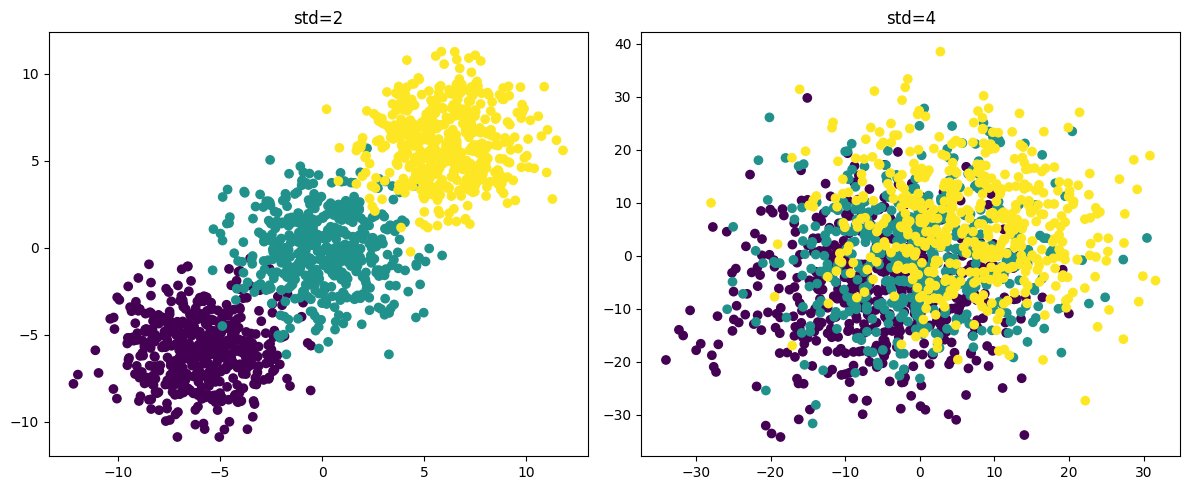

In [13]:
import torch
import matplotlib.pyplot as plt

# 生成数据
torch.manual_seed(420)
f, l = tensorGenCla(deg_dispersion=[6,2])
f1, l1 = tensorGenCla(deg_dispersion=[6,10])#离散程度大

# 绘制图形
plt.figure(figsize=(12, 5))

# 第一个子图（左侧）
plt.subplot(121)
plt.scatter(f[:,0], f[:,1], c=l.squeeze())  
plt.title("std=2")

# 第二个子图（右侧）
plt.subplot(122)
plt.scatter(f1[:,0], f1[:,1], c=l1.squeeze())  
plt.title("std=4")

plt.tight_layout()
plt.show()

### 三.创建小批量切分函数

In [14]:
import random
import torch

def data_iter(batch_size, features, labels):
    """
    数据切分函数
    
    :param batch_size: 每个子数据集包含多少数据
    :param featurs: 输入的特征张量
    :param labels：输入的标签张量
    :return l：包含batch_size个列表，每个列表切分后的特征和标签所组成 
    """
    # 获取总样本数量
    num_examples = len(features)
    
    # 创建从0到num_examples-1的索引列表
    indices = list(range(num_examples))
    
    # 随机打乱索引顺序，实现数据的随机化
    random.shuffle(indices)
    
    # 初始化空列表用于存储所有批量数据
    l = []
    
    # 以batch_size为步长遍历所有样本索引
    for i in range(0, num_examples, batch_size):
        # i 是当前批量在总数据中的起始位置
        # 获取当前批量的索引范围，处理最后一个批量可能不足的情况
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        
        # 使用索引选择对应的特征和标签数据，并作为一个批量添加到结果列表
        l.append([torch.index_select(features, 0, j), torch.index_select(labels, 0, j)])
    
    # 返回包含所有批量的列表
    return l


### **完整流程示例**

假设：

- `num_examples=100`（100个样本），
- `batch_size=16`，
- `indices` 是打乱的 `[0, 1, 2, ..., 99]` 的某种排列（如 `[3, 1, 4, 2, ...]`）。

1. 第一次循环

   i=0
   

   - `batch_indices = indices[0:16]` → 取前16个打乱的索引。
   - `yield features[indices[0:16]], labels[indices[0:16]]` → 返回第1个批次的数据。

2. 第二次循环
   
   i=16


   - `batch_indices = indices[16:32]` → 取接下来的16个索引。
   - `yield features[indices[16:32]], labels[indices[16:32]]` → 返回第2个批次的数据。

3. **... 直到所有样本遍历完毕**。